In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [3]:
import fsps
import sedpy
import prospect
from prospect.sources.constants import cosmo
import exspect
import sys
sys.path.append('/Users/jiaxuanl/Dropbox (Princeton)/Research/popsed/')

In [4]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [29]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

In [20]:
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
# we only vary stellar mass and tau.
model = mock.build_model(mass=5e10, zred=0.05, 
                         tage=12.0, tau=2.5, 
                         sfh=1, add_dustabs=False,
                         uniform_priors=True)
sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, avg = 50 Myr
model.params['sfr'] = sfr
model.params['ssfr'] = model.params['sfr'] / model.params['mass']

For this simple $\tau$ model, we have (assuming all stellar mass is formed in this way)
$$ \mathrm{SFR}(t_0) = \frac{M}{\tau (e^{t_0/\tau} - 1)}$$

$$ \mathrm{sSFR}(t_0) = \frac{1}{\tau (e^{t_0/\tau} - 1)}$$

Text(0, 0.5, '$\\rm sSFR$ (Gyr$^{-1}$)')

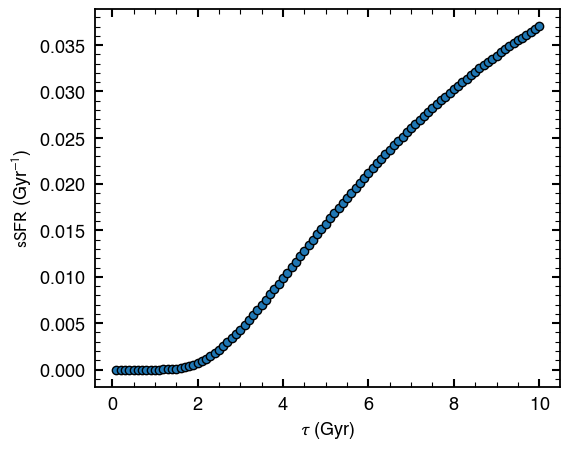

In [21]:
taus = np.linspace(0.1, 10, 100)
ssfr = 1 / (taus) / (np.exp(13.088 / taus) - 1)

plt.scatter(taus, ssfr)
plt.xlabel(r'$\tau$ (Gyr)')
plt.ylabel(r'$\rm sSFR$ (Gyr$^{-1}$)')

#plt.yscale('log')
#plt.ylim(1e-4, 0)

In [22]:
cosmo.age(0.05).value - 12.0

1.088109006102533

In [23]:
cosmo.age(6)

<Quantity 0.94462862 Gyr>

In [24]:
# Sample the stellar mass -- SFR plane
sfr_set = []
mass_set = []
mwa_set = []
tau_set = []

for mass in np.logspace(9, 12, 10):
    for tau in 1 / np.logspace(-1, 0., 20): #np.linspace(0.1, 10, 15):#np.logspace(-0.3, 1.2, 15):
        model = mock.build_model(mass=mass, zred=0.05, 
                                 tage=12.0, tau=tau, 
                                 sfh=1, add_dustabs=False,
                                 uniform_priors=True)
        sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, avg = 50 Myr
        sfr_set.append(float(sfr))
        mass_set.append(mass)
        mwa_set.append(parametric_mwa(tau=tau, tage=cosmo.age(0.05).value))
        tau_set.append(tau)

Text(0, 0.5, '$\\log\\ \\mathrm{SFR}\\ [M_\\odot\\ \\rm{yr}^{-1}]$')

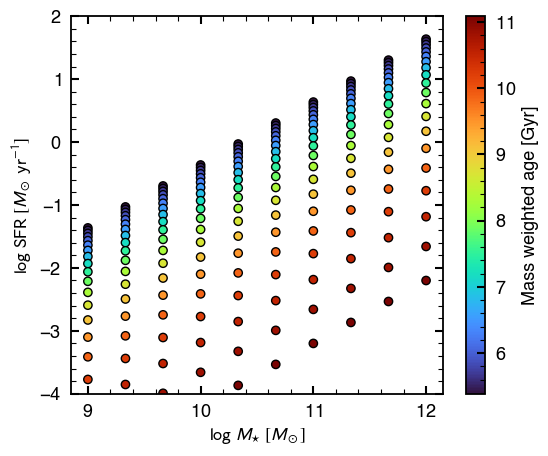

In [25]:
plt.scatter(np.log10(mass_set), np.log10(sfr_set), c=mwa_set)
plt.colorbar(label='Mass weighted age [Gyr]')
plt.ylim(-4, 2)

plt.xlabel(r'$\log\ M_{\star}\ [M_\odot]$')
plt.ylabel(r'$\log\ \mathrm{SFR}\ [M_\odot\ \rm{yr}^{-1}]$')

In [27]:
obs = {}

In [30]:
for tau in 1 / np.logspace(-1, 0., 10):
    obs[tau] = mock.build_obs(mass=5e10, zred=0.05, logzsol=-0.5,
                         tage=12.0, tau=tau, 
                         sfh=1, uniform_priors=True, 
                         snr_spec=0, snr_phot=20, 
                         filterset=sdss, 
                         continuum_optimize=False)
# obs['mag'] = - 2.5 * np.log10(obs['maggies'])

In [31]:
obs

{10.0: {'filters': [<class 'sedpy.observate.Filter'>(sdss_u0),
   <class 'sedpy.observate.Filter'>(sdss_g0),
   <class 'sedpy.observate.Filter'>(sdss_r0),
   <class 'sedpy.observate.Filter'>(sdss_i0),
   <class 'sedpy.observate.Filter'>(sdss_z0)],
  'maggies': array([9.30195779e-08, 2.54624161e-07, 4.30603934e-07, 5.49406134e-07,
         7.04407915e-07]),
  'wavelength': None,
  'spectrum': None,
  'true_spectrum': array([ 5.95194893e-11, -6.66934213e-14, -1.05668512e-15, ...,
          2.09371787e-09,  2.03849342e-09,  1.92620130e-09]),
  'true_maggies': array([8.19308522e-08, 2.46870780e-07, 4.11904117e-07, 5.35905972e-07,
         6.82198336e-07]),
  'mock_params': {'zred': array([0.05]),
   'mass': array([5.e+10]),
   'logzsol': array([-0.5]),
   'dust2': array([0.6]),
   'sfh': array([1]),
   'tage': array([12.]),
   'imf_type': array([2]),
   'dust_type': array([0]),
   'tau': array([10.])},
  'maggies_unc': array([4.09654261e-09, 1.23435390e-08, 2.05952058e-08, 2.67952986e-08,


array([1.])

In [52]:
from matplotlib.colorbar import cm
from matplotlib.colors import Normalize

In [84]:
 # current SFR, avg = 50 Myr

array([0.00031502])

No handles with labels found to put in legend.


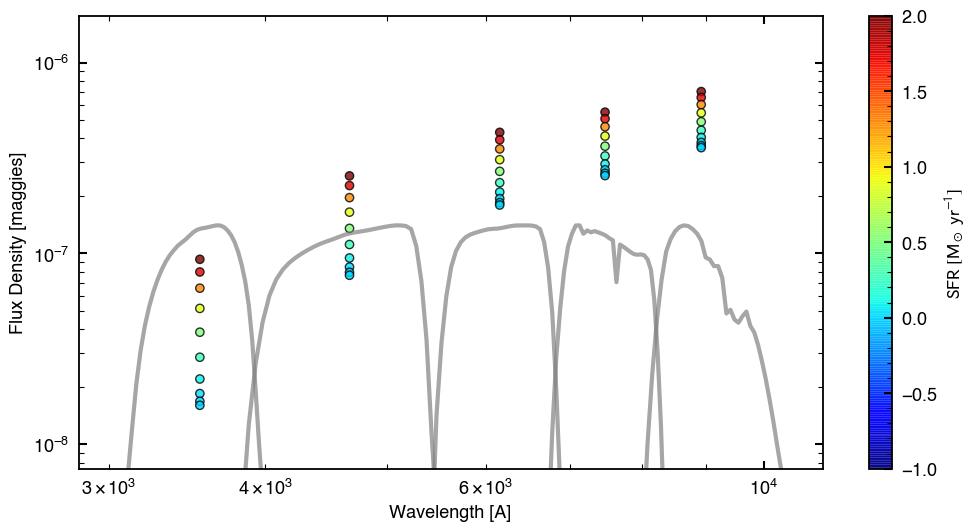

In [87]:
# --- Plot the Data ----
# This is why we stored these...
wphot = list(obs.values())[0]["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = list(obs.values())[0]["maggies"].min()*0.8, list(obs.values())[0]["maggies"].max()/0.4
plt.figure(figsize=(12, 6))

# plot all the data
for ob in list(obs.values()):
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, ob['maggies'],
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=1, vmax=10,
#          c=np.ones_like(wphot) * ob['mock_params']['tau'], cmap='jet')
    sct = plt.scatter(wphot, ob['maggies'],
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-1, vmax=2,
         c=np.ones_like(wphot) * sfr, cmap='jet')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# plot Filters
for f in list(obs.values())[0]['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin / 10, ymax])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

In [232]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)